# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [3]:
# Numerical stability when computing exp
d = np.array([100, 200, 1000])

# A. example that fails
# np.exp(d)/np.sum(np.exp(d))

# B. works if we subtract max(d)
d2 = d - np.max(d)
np.exp(d2)/np.sum(np.exp(d2))

array([0., 0., 1.])

In [11]:
X = X_dev
y = y_dev
W = np.random.randn(3073, 10) * 0.0001
D, C = W.shape

mask = np.eye(C, dtype=bool)[y]

In [12]:
i=1
scores = X[i].dot(W)
scores -= np.max(scores)
exp_scores = np.exp(scores)
ps = exp_scores / np.sum(exp_scores)
loss = -1 * np.log(ps[y[i]])



In [14]:
mask.astype('float')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [15]:
(ps[:,np.newaxis]* X[i]).shape

(10, 3073)

In [17]:
S = X.dot(W)
S -= np.max(S, axis=1)[:,np.newaxis]
ES = np.exp(S)
P = ES / np.sum(ES, axis=1)[:,np.newaxis]

loss = np.sum( -1*np.log(P[mask]) )
loss

1173.6513252449804

array([0.08189802, 0.10162321, 0.11542703, 0.08434392, 0.10401574,
       0.11226947, 0.098643  , 0.08765806, 0.12140318, 0.09271836])

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [18]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.337826
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ Since we're starting with random weights, all class labels will be equally likely, or p=0.1 since we have 10 categories.



In [19]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.812383 analytic: -1.812451, relative error: 1.875397e-05
numerical: 0.249142 analytic: 0.249321, relative error: 3.574058e-04
numerical: -1.245171 analytic: -1.244998, relative error: 6.958059e-05
numerical: 0.531891 analytic: 0.531600, relative error: 2.737203e-04
numerical: -2.261349 analytic: -2.261405, relative error: 1.232206e-05
numerical: 1.148101 analytic: 1.147985, relative error: 5.078785e-05
numerical: 0.263355 analytic: 0.263337, relative error: 3.486981e-05
numerical: -1.232874 analytic: -1.232775, relative error: 4.039261e-05
numerical: 3.370047 analytic: 3.369919, relative error: 1.898375e-05
numerical: 1.300608 analytic: 1.300706, relative error: 3.765829e-05
numerical: -0.333233 analytic: -0.319297, relative error: 2.135663e-02
numerical: 0.614413 analytic: 0.613541, relative error: 7.098308e-04
numerical: -1.252154 analytic: -1.260990, relative error: 3.515876e-03
numerical: 0.834931 analytic: 0.848953, relative error: 8.327208e-03
numerical: 0.709228 an

In [74]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.341784e+00 computed in 0.134209s
vectorized loss: 2.341784e+00 computed in 0.006243s
Loss difference: 0.000000
Gradient difference: 0.000000


Starting hyperparameter search...
Training  took 11.876985s   lr= 5e-07    reg= 50000.0


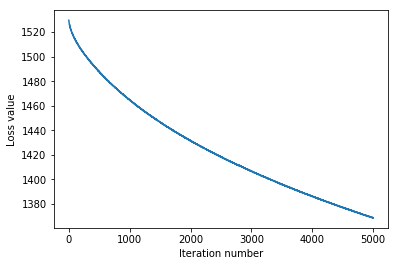

Training  took 11.182304s   lr= 5e-07    reg= 80000.0


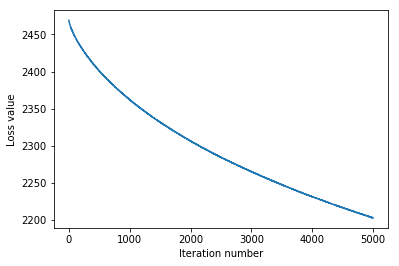

Training  took 13.333505s   lr= 5e-07    reg= 100000.0


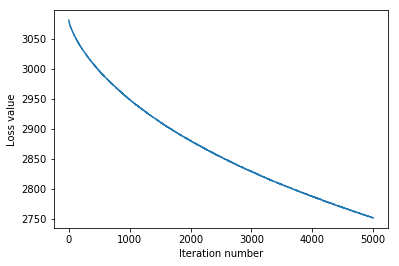

Training  took 13.284744s   lr= 8e-07    reg= 50000.0


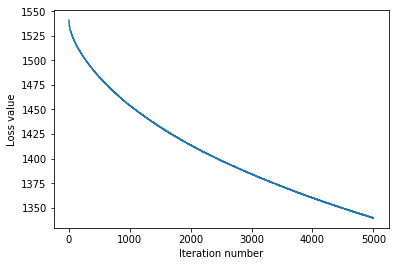

Training  took 13.853246s   lr= 8e-07    reg= 80000.0


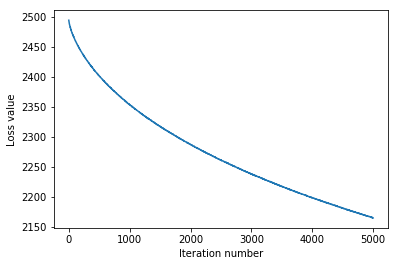

Training  took 13.714255s   lr= 8e-07    reg= 100000.0


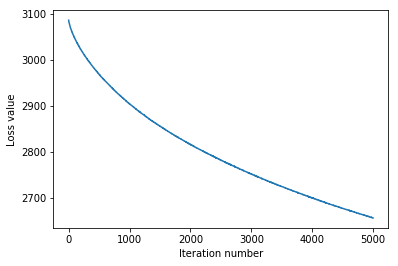

Training  took 14.411654s   lr= 9e-07    reg= 50000.0


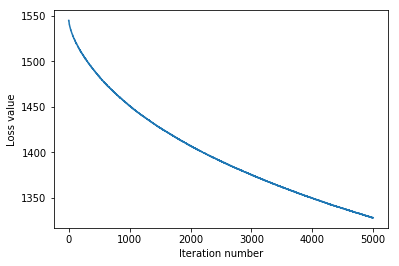

Training  took 13.580471s   lr= 9e-07    reg= 80000.0


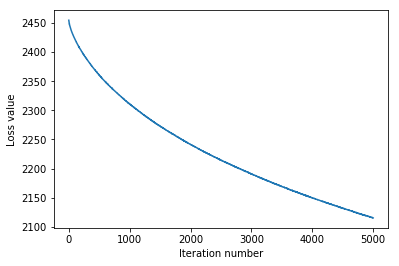

Training  took 15.458639s   lr= 9e-07    reg= 100000.0


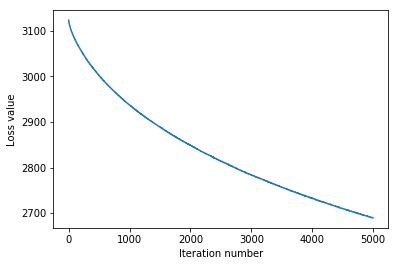

Training  took 15.447447s   lr= 1e-06    reg= 50000.0


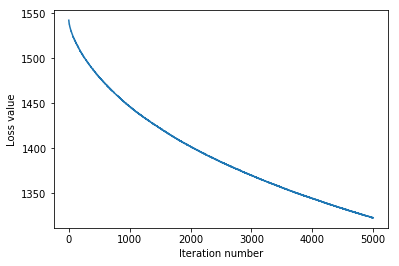

Training  took 13.940935s   lr= 1e-06    reg= 80000.0


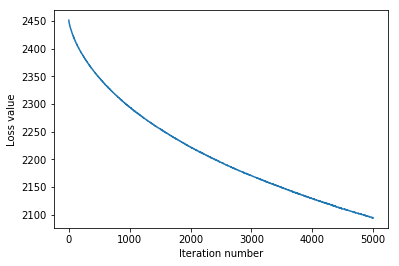

Training  took 14.672149s   lr= 1e-06    reg= 100000.0


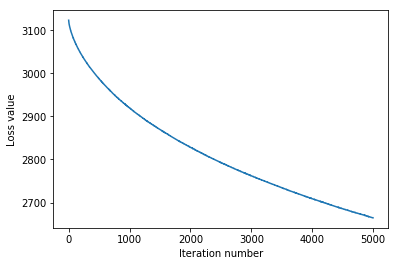

Training  took 19.019123s   lr= 1e-05    reg= 50000.0


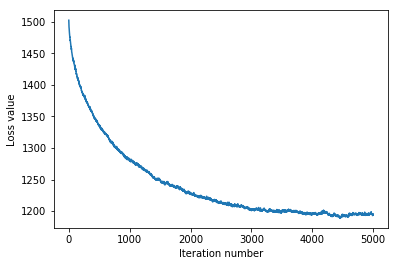

Training  took 14.137120s   lr= 1e-05    reg= 80000.0


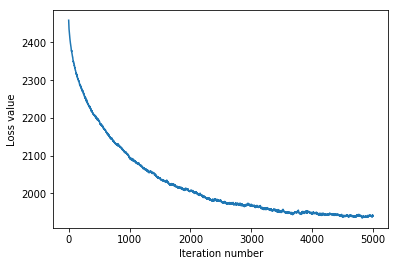

Training  took 13.102689s   lr= 1e-05    reg= 100000.0


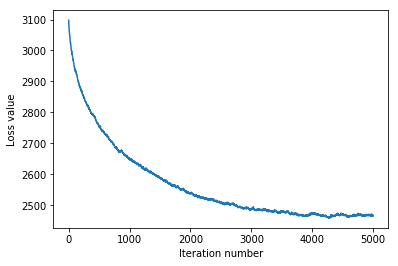

lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.372245 val accuracy: 0.362000
lr 5.000000e-07 reg 8.000000e+04 train accuracy: 0.369265 val accuracy: 0.375000
lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.370122 val accuracy: 0.360000
lr 8.000000e-07 reg 5.000000e+04 train accuracy: 0.389224 val accuracy: 0.361000
lr 8.000000e-07 reg 8.000000e+04 train accuracy: 0.390571 val accuracy: 0.374000
lr 8.000000e-07 reg 1.000000e+05 train accuracy: 0.388918 val accuracy: 0.366000
lr 9.000000e-07 reg 5.000000e+04 train accuracy: 0.395102 val accuracy: 0.363000
lr 9.000000e-07 reg 8.000000e+04 train accuracy: 0.393286 val accuracy: 0.377000
lr 9.000000e-07 reg 1.000000e+05 train accuracy: 0.392367 val accuracy: 0.384000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.397592 val accuracy: 0.363000
lr 1.000000e-06 reg 8.000000e+04 train accuracy: 0.400653 val accuracy: 0.370000
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.396163 val accuracy: 0.376000
lr 1.000000e-05 reg 5.000000

In [80]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [5e-7, 8e-7, 9e-7, 1e-6, 1e-5]
regularization_strengths = [5e4, 8e4, 1e5]


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



print("Starting hyperparameter search...")
NUM_ITERATIONS = 5000
PRINT_LOSS_HISTORY = True

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        tic = time.time()
        loss_hist = softmax.train(X_train, y_train,
                              learning_rate=lr,
                              reg=reg,
                              num_iters=NUM_ITERATIONS, verbose=False)
        toc = time.time()
        print('Training  took %fs' % (toc - tic), '  lr=', lr, '   reg=', reg)
        if PRINT_LOSS_HISTORY:
            plt.plot(loss_hist)
            plt.xlabel('Iteration number')
            plt.ylabel('Loss value')
            plt.show()

        # evaluate
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        
        # store results
        results[(lr,reg)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

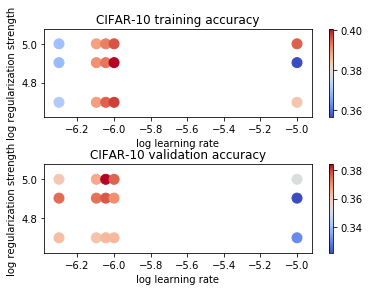

In [81]:
# Visualize the cross-validation results
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [82]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.366000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ Yes. 


$\color{blue}{\textit Your Explanation:}$ So long as the point is well classified (margin > 1) then it will not appear in the SVM loss. This is not possible for softmax since it will never be p=1.



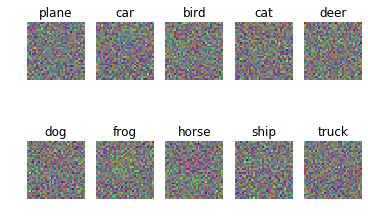

In [83]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])